# ***PREDICCIÓN DE ENFERMEDADES MODELO AI - CLOUD***

In [1]:
%%bash
python -V
pip -q install --upgrade pip
pip -q install pandas numpy scikit-learn tensorflow seaborn matplotlib imbalanced-learn

Python 3.12.12
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.4 MB/s eta 0:00:00


In [2]:
from pathlib import Path
import pandas as pd
import io, re, os
try:
    from google.colab import files
    IN_COLAB = True
except Exception:
    IN_COLAB = False

csv_path = 'dataset_salud_traducido.csv'
if IN_COLAB and not Path(csv_path).exists():
    print('Sube tu archivo dataset_salud_traducido…')
    uploaded = files.upload()
    if csv_path not in uploaded:
        # Renombrar el primero que tenga extensión .csv a health_dataset.csv
        for k in uploaded.keys():
            if k.lower().endswith('.csv'):
                os.rename(k, csv_path)
                break

# Lectura del CSV
read_kwargs = dict(encoding='utf-8', on_bad_lines='skip')
try:
    df = pd.read_csv(csv_path, **read_kwargs)
except UnicodeDecodeError:
    df = pd.read_csv(csv_path, encoding='latin-1', on_bad_lines='skip')

print('Filas:', len(df), '| Columnas:', len(df.columns))
df.head(3)

Filas: 12091 | Columnas: 17


,Enfermedad,Síntoma_1,Síntoma_2,Síntoma_3,Síntoma_4,Síntoma_5,Síntoma_6,Síntoma_7,Síntoma_8,Síntoma_9,Síntoma_10,Síntoma_11,Síntoma_12,Síntoma_13,Síntoma_14,Síntoma_15,Síntoma_16
0,Roséola,Secreción nasal,Erupción,Ojos rojos,Pérdida de apetito,Erupciones,Febril,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Roséola,Fiebre alta,Secreción nasal,Irritabilidad,Dolor de cabeza,Tos,Erupciones,Escalofríos,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Infección por Norovirus,Calambres estomacales,Náuseas,Fatiga,Dolor abdominal,Pérdida de apetito,Deshidratación,Escalofríos,Sudoración,Erupciones,Malestar general,Fiebre,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12091 entries, 0 to 12090
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Enfermedad  12091 non-null  object
 1   Síntoma_1   12091 non-null  object
 2   Síntoma_2   12091 non-null  object
 3   Síntoma_3   12091 non-null  object
 4   Síntoma_4   12091 non-null  object
 5   Síntoma_5   11866 non-null  object
 6   Síntoma_6   11357 non-null  object
 7   Síntoma_7   10354 non-null  object
 8   Síntoma_8   8736 non-null   object
 9   Síntoma_9   6699 non-null   object
 10  Síntoma_10  4550 non-null   object
 11  Síntoma_11  2639 non-null   object
 12  Síntoma_12  1312 non-null   object
 13  Síntoma_13  520 non-null    object
 14  Síntoma_14  169 non-null    object
 15  Síntoma_15  42 non-null     object
 16  Síntoma_16  5 non-null      object
dtypes: object(17)
memory usage: 1.6+ MB


None

Clases (Disease) y conteo:


,count
Enfermedad,
Infección por Norovirus,3538
Shigellosis (Disentería Bacilar),3506
Roséola,3446
"Enfermedad de manos, pies y boca",891
Paperas,228
Escarlatina,190
Tos ferina (Pertussis),98
Quinta enfermedad,46
Resfriado común,44


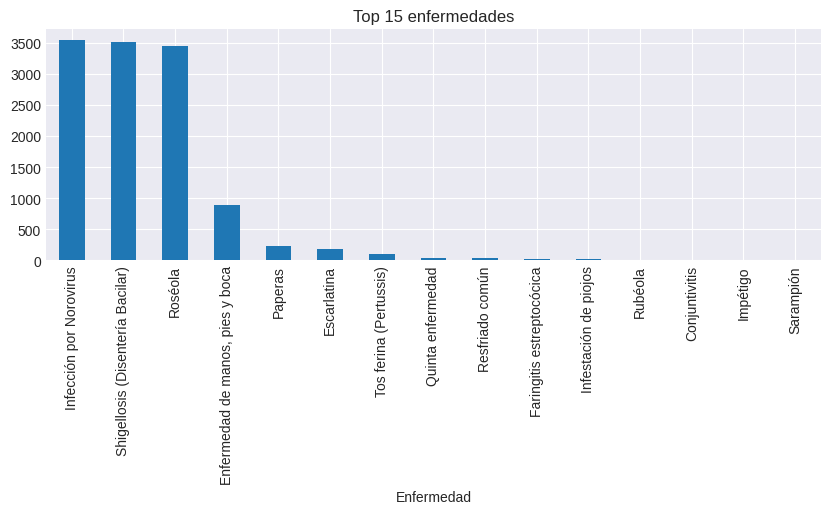

In [4]:
import numpy as np, seaborn as sns, matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')
display(df.info())
print('Clases (Disease) y conteo:')
display(df['Enfermedad'].value_counts())
# top 15 clases
df['Enfermedad'].value_counts().head(15).plot(kind='bar', figsize=(10,3), title='Top 15 enfermedades')
plt.show()

In [8]:
import re
SYMPTOM_COLS = [c for c in df.columns if c.startswith('Síntoma_')]
assert 'Enfermedad' in df.columns, 'La columna objetivo debe llamarse Enfermedad'

def normalize_symptom(s: str) -> str:
    if not isinstance(s, str) or not s.strip():
        return ''
    s = s.strip().strip(')"(')
    s = s.replace(r'\-','-')
    s = re.sub(r'\s+', ' ', s)
    s = s.lower()

    mapping = {
        'rashes':'rash',
        'running nose':'runny nose',
        'headache and body aches':'body aches',
    }
    if s in mapping: s = mapping[s]
    return s

symptom_sets = []
for _, row in df.iterrows():
    items = []
    for c in SYMPTOM_COLS:
        val = normalize_symptom(row.get(c, ''))
        if val:
            items.append(val)
    # quitar duplicados
    seen = set()
    uniq = [x for x in items if not (x in seen or seen.add(x))]
    symptom_sets.append(uniq)

df_features = pd.DataFrame({'Enfermedad': df['Enfermedad'].astype(str), 'sintomas': symptom_sets})
df_features.head(3)

,Enfermedad,sintomas
0,Roséola,"[secreción nasal, erupción, ojos rojos, pérdid..."
1,Roséola,"[fiebre alta, secreción nasal, irritabilidad, ..."
2,Infección por Norovirus,"[calambres estomacales, náuseas, fatiga, dolor..."


In [9]:
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Identificar y remover clases con una sola instancia para permitir split estratificado
class_counts = df_features['Enfermedad'].value_counts()
single_instance_classes = class_counts[class_counts == 1].index

if not single_instance_classes.empty:
    print(f"Removiendo {len(single_instance_classes)} clases con una sola instancia del dataset principal para estratificación: {list(single_instance_classes)}")
    df_features_filtered = df_features[~df_features['Enfermedad'].isin(single_instance_classes)].copy()
else:
    df_features_filtered = df_features.copy()
    print("No se encontraron clases con una sola instancia en el dataset principal.")

mlb = MultiLabelBinarizer()
X = mlb.fit_transform(df_features_filtered['sintomas'])
symptom_vocab = list(mlb.classes_)

le = LabelEncoder()
y = le.fit_transform(df_features_filtered['Enfermedad'])
class_names = list(le.classes_)

X_train, X_temp_raw, y_train, y_temp_raw = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

unique_classes_in_y_temp_raw, counts_in_y_temp_raw = np.unique(y_temp_raw, return_counts=True)
single_instance_classes_in_y_temp_indices = unique_classes_in_y_temp_raw[counts_in_y_temp_raw == 1]

if len(single_instance_classes_in_y_temp_indices) > 0:
    single_instance_class_names_in_y_temp = [class_names[idx] for idx in single_instance_classes_in_y_temp_indices]
    print(f"Removiendo {len(single_instance_classes_in_y_temp_indices)} clases con una sola instancia del conjunto temporal (para validación/prueba) para permitir la estratificación: {single_instance_class_names_in_y_temp}")

    samples_to_keep_mask = ~np.isin(y_temp_raw, single_instance_classes_in_y_temp_indices)
    X_temp = X_temp_raw[samples_to_keep_mask]
    y_temp = y_temp_raw[samples_to_keep_mask]
else:
    X_temp = X_temp_raw
    y_temp = y_temp_raw

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = {int(c): float(w) for c, w in zip(classes, class_weights)}

X.shape, len(class_names), len(symptom_vocab), class_weight_dict

No se encontraron clases con una sola instancia en el dataset principal.
Removiendo 1 clases con una sola instancia del conjunto temporal (para validación/prueba) para permitir la estratificación: ['Candidiasis oral']


((12091, 109),
 16,
 109,
 {0: 176.3125,
  1: 66.1171875,
  2: 0.84765625,
  3: 3.976973684210526,
  4: 26.446875,
  5: 66.1171875,
  6: 0.21362580775444265,
  7: 27.838815789473685,
  8: 3.3266509433962264,
  9: 16.529296875,
  10: 17.0625,
  11: 0.21929415422885573,
  12: 52.89375,
  13: 105.7875,
  14: 0.21554095354523228,
  15: 7.665760869565218})

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.keras.utils.set_random_seed(42)

input_dim = X_train.shape[1]
num_classes = len(class_names)
model = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.35),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.35),
    layers.Dense(num_classes, activation='softmax')
])
model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │        56,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │         4,112 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 194,832 (761.06 KB)

 Trainable params: 193,296 (755.06 KB)

 Non-trainable params: 1,536 (6.00 KB)

Epoch 1/50

Epoch 1: val_accuracy improved from -inf to 0.87204, saving model to best_model.keras
265/265 - 5s - 21ms/step - accuracy: 0.7651 - loss: 0.9832 - val_accuracy: 0.8720 - val_loss: 0.6516
Epoch 2/50

Epoch 2: val_accuracy improved from 0.87204 to 0.97297, saving model to best_model.keras
265/265 - 2s - 6ms/step - accuracy: 0.9374 - loss: 0.0744 - val_accuracy: 0.9730 - val_loss: 0.0783
Epoch 3/50

Epoch 3: val_accuracy improved from 0.97297 to 0.97683, saving model to best_model.keras
265/265 - 1s - 6ms/step - accuracy: 0.9604 - loss: 0.0390 - val_accuracy: 0.9768 - val_loss: 0.0567
Epoch 4/50

Epoch 4: val_accuracy improved from 0.97683 to 0.98014, saving model to best_model.keras
265/265 - 2s - 7ms/step - accuracy: 0.9674 - loss: 0.0285 - val_accuracy: 0.9801 - val_loss: 0.0424
Epoch 5/50

Epoch 5: val_accuracy did not improve from 0.98014
265/265 - 2s - 8ms/step - accuracy: 0.9622 - loss: 0.0340 - val_accuracy: 0.9741 - val_loss: 0.0504
Epoch 6/50

Epoch 6: val_accuracy d

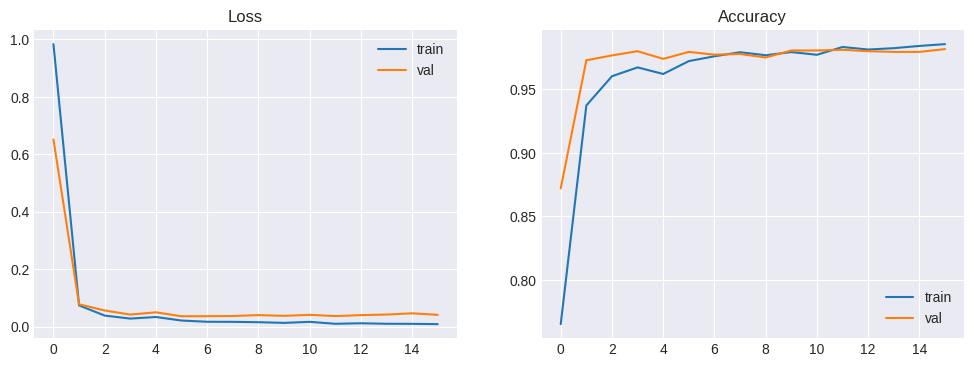

In [11]:
early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = keras.callbacks.ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[early, checkpoint],
    verbose=2
)
# Curvas
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.plot(history.history['loss'], label='train'); plt.plot(history.history['val_loss'], label='val'); plt.title('Loss'); plt.legend()
plt.subplot(1,2,2); plt.plot(history.history['accuracy'], label='train'); plt.plot(history.history['val_accuracy'], label='val'); plt.title('Accuracy'); plt.legend()
plt.show()

Test accuracy: 0.9752 | Test loss: 0.0439
Clasification report (macro/micro):
                                  precision    recall  f1-score   support

                   Conjuntivitis     1.0000    1.0000    1.0000         2
Enfermedad de manos, pies y boca     1.0000    1.0000    1.0000       134
                     Escarlatina     1.0000    1.0000    1.0000        29
       Faringitis estreptocócica     0.8000    1.0000    0.8889         4
                        Impétigo     1.0000    1.0000    1.0000         2
         Infección por Norovirus     0.9900    0.9303    0.9592       531
           Infestación de piojos     1.0000    1.0000    1.0000         4
                         Paperas     1.0000    1.0000    1.0000        35
               Quinta enfermedad     1.0000    1.0000    1.0000         7
                 Resfriado común     1.0000    1.0000    1.0000         6
                         Roséola     0.9981    0.9903    0.9942       517
                         Rubéola 

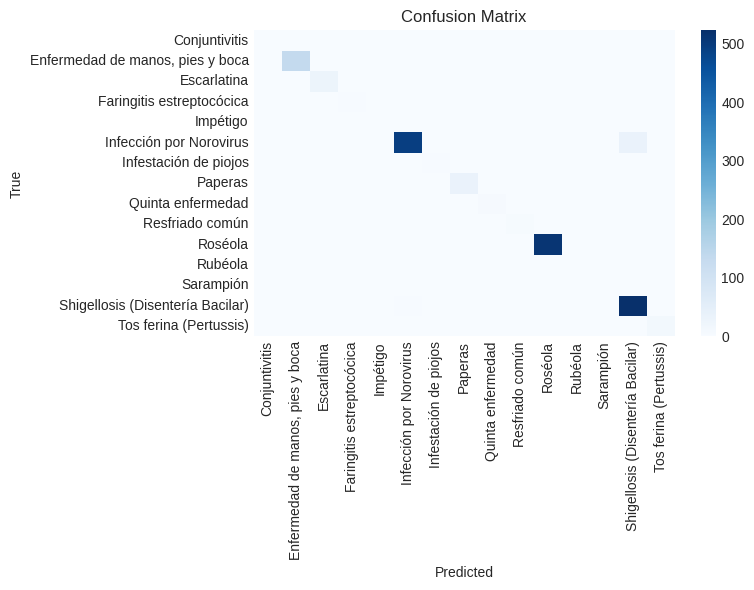

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np, seaborn as sns, matplotlib.pyplot as plt

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f'Test accuracy: {test_acc:.4f} | Test loss: {test_loss:.4f}')
y_pred = model.predict(X_test, verbose=0).argmax(axis=1)

unique_test_labels = np.unique(y_test)

filtered_class_names = [class_names[label] for label in unique_test_labels]

print('Clasification report (macro/micro):')
print(classification_report(y_test, y_pred, target_names=filtered_class_names, digits=4))


cm = confusion_matrix(y_test, y_pred, labels=unique_test_labels)

plt.figure(figsize=(8,6))
sns.heatmap(cm, cmap='Blues', cbar=True, xticklabels=filtered_class_names, yticklabels=filtered_class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.tight_layout(); plt.show()

In [15]:
import json
# Guardar modelo en formato Keras y TFLite
model.save('health_nn_model.keras')
with open('class_names.json','w') as f: json.dump(class_names, f, indent=2)
with open('symptom_vocab.json','w') as f: json.dump(symptom_vocab, f, indent=2)
try:
    import tensorflow as tf
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    with open('health_nn_model.tflite','wb') as f: f.write(tflite_model)
    print('Exportado también a health_nn_model.tflite')
except Exception as e:
    print('No se pudo exportar a TFLite:', e)

print('Artefactos guardados: health_nn_model.keras, class_names.json, symptom_vocab.json')

# Descarga (Colab)
try:
    from google.colab import files
    for fn in ['health_nn_model.keras','class_names.json','symptom_vocab.json']:
        try:
            files.download(fn)
        except Exception as e:
            print('No se pudo descargar', fn, e)
except Exception:
    pass

Saved artifact at '/tmp/tmpzlnqaoep'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 109), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 16), dtype=tf.float32, name=None)
Captures:
  134873325106192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134873325106960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134873325108688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134873325107920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134873325105808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134873325108496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134873325108304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134873325108880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134873325107536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134873325106576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134873325109072: Tens

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
# Escribe una lista de síntomas
input_symptoms = [
    'Diarrea', 'Dolor abdominal', 'Vómitos'
]

def vectorize(symptoms_list):
    norm = [normalize_symptom(s) for s in symptoms_list]
    Xq = mlb.transform([norm])
    return Xq

Xq = vectorize(input_symptoms)
probs = model.predict(Xq, verbose=0)[0]
topk = 5
idx = probs.argsort()[::-1][:topk]
for r, i in enumerate(idx, 1):
    print(f'{r}. {class_names[i]} — prob={probs[i]:.4f}')


1. Infección por Norovirus — prob=0.6129
2. Roséola — prob=0.2795
3. Impétigo — prob=0.0207
4. Candidiasis oral — prob=0.0189
5. Escarlatina — prob=0.0147


In [ ]:
%%bash
pip install google-cloud-translate

### Configuración de la API de Google Cloud Translation

Para usar la API de Google Cloud Translation, necesitarás:
1.  **Habilitar la API de Cloud Translation** en tu proyecto de Google Cloud.
2.  **Crear una Cuenta de Servicio (Service Account)** y descargar su clave JSON. Guarda este archivo JSON en un lugar seguro.
3.  **Configurar la variable de entorno** `GOOGLE_APPLICATION_CREDENTIALS` para que apunte a la ruta de tu archivo JSON de credenciales.

Aquí tienes un ejemplo de cómo podrías cargar las credenciales si el archivo JSON está en tu entorno de Colab (por ejemplo, después de subirlo).


In [ ]:
import os

# Sube tu archivo de credenciales JSON aquí o especifica la ruta
# Por ejemplo, si lo subes a '/content/your-service-account-key.json'
# Si lo subes en Colab, puedes usar files.upload() como en la carga del dataset.
# files.upload() (descomentar y ejecutar si necesitas subirlo)

# Reemplaza con la ruta a tu archivo de credenciales
# os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/content/your-service-account-key.json'

# Solo para probar, si no tienes la API key configurada, esto fallará.
# Puedes comentar esta celda si prefieres simular la traducción por ahora.

# from google.cloud import translate_v2 as translate
# try:
#     translate_client = translate.Client()
#     print("Cliente de Google Translate inicializado correctamente.")
# except Exception as e:
#     print(f"Error al inicializar el cliente de Google Translate. Asegúrate de que las credenciales estén configuradas: {e}")

### Pasos para configurar las credenciales de Google Cloud Translation API en Colab

1.  **Asegúrate de tener tu archivo JSON de credenciales de Google Cloud.**
2.  **Ejecuta la siguiente celda para subir tu archivo JSON.** Cuando se te pida, selecciona el archivo que descargaste.

In [ ]:
from google.colab import files
import os

print('Por favor, selecciona tu archivo JSON de clave de cuenta de servicio:')
uploaded = files.upload()

# Asume que subes un solo archivo JSON
json_filename = list(uploaded.keys())[0]
print(f'Archivo subido: {json_filename}')

# Mueve el archivo a una ubicación predecible si es necesario, o simplemente usa el nombre subido.
# Si tienes múltiples archivos subidos, asegúrate de elegir el correcto.
# En este ejemplo, asumimos que es el único archivo JSON que necesitas.

# Configura la variable de entorno
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = f'/content/{json_filename}'

print(f'Variable de entorno GOOGLE_APPLICATION_CREDENTIALS configurada a: /content/{json_filename}')
print('Ahora puedes intentar ejecutar la celda con la función `predict_disease_from_spanish_symptoms` de nuevo.')

Después de ejecutar la celda anterior y subir tu archivo, **vuelve a ejecutar la celda `d1c686e4`** para que el cliente de Google Translate pueda inicializarse correctamente con las nuevas credenciales. Deberías ver un mensaje indicando que la API de Google Cloud Translation está activa, y las predicciones de enfermedades se mostrarán en español.

### Función de traducción y inferencia combinada

Ahora, crearemos una función que primero traduce los síntomas de español a inglés y luego usa tu modelo entrenado para hacer la predicción. Para esta demostración, simularé la traducción si no tienes las credenciales de la API configuradas.

In [ ]:
from google.cloud import translate_v2 as translate

# Initial global state for translation. We assume it's disabled unless proven otherwise
# or user explicitly sets credentials.
_translation_client = None
_translation_enabled = False

try:
    _translation_client = translate.Client()
    # Test if the client is actually functional by trying a small, safe API call
    # A common way is to attempt to get supported languages, which doesn't require specific input
    _translation_client.get_languages() # This will raise if auth fails
    _translation_enabled = True
    print("Google Cloud Translation API está activa.")
except Exception as e:
    _translation_enabled = False
    print(f"Error al inicializar o usar el cliente de Google Translate. La traducción será simulada. Detalles: {e}")

# Función para traducir síntomas de español a inglés
def translate_symptoms_to_english(symptoms_list_es: list[str]) -> list[str]:
    global _translation_enabled
    global _translation_client

    if not _translation_enabled:
        print("Simulando traducción de síntomas...")
        # Puedes expandir este diccionario para más síntomas si no usas la API real
        mock_symptom_translations = {
            'diarrea': 'diarrhea',
            'dolor abdominal': 'abdominal pain',
            'vómitos': 'vomiting',
            'fiebre': 'fever',
            'escalofríos': 'chills',
            'dolor de cabeza': 'headache',
            'sarpullido': 'rash',
            'nariz que moquea': 'runny nose',
            'tos': 'cough'
        }
        translated_symptoms = [mock_symptom_translations.get(s.lower(), s) for s in symptoms_list_es]
        return translated_symptoms

    translated_symptoms = []
    try:
        for symptom in symptoms_list_es:
            result = _translation_client.translate(symptom, source_language='es', target_language='en')
            translated_symptoms.append(result['translatedText'])
        return translated_symptoms
    except Exception as e:
        print(f"Error durante la traducción real de síntomas: {e}. Volviendo a simulación.")
        _translation_enabled = False # Prevent future attempts at real translation
        return translate_symptoms_to_english(symptoms_list_es) # Recursive call to use mock

# Nueva función para traducir nombres de enfermedades de inglés a español
def translate_disease_to_spanish(disease_name_en: str) -> str:
    global _translation_enabled
    global _translation_client

    if not _translation_enabled:
        # Si la API no está activa, simplemente devuelve el nombre en inglés
        # o podrías añadir un mock_disease_translations si quieres simular también esto
        return disease_name_en

    try:
        result = _translation_client.translate(disease_name_en, source_language='en', target_language='es')
        return result['translatedText']
    except Exception as e:
        print(f"Error durante la traducción real de enfermedades: {e}. Devolviendo nombre en inglés.")
        _translation_enabled = False # Prevent future attempts at real translation
        return disease_name_en

def predict_disease_from_spanish_symptoms(spanish_symptoms: list[str], model, mlb, class_names, normalize_symptom):
    # 1. Traducir síntomas a inglés
    english_symptoms = translate_symptoms_to_english(spanish_symptoms)
    print(f"Síntomas traducidos (a inglés): {english_symptoms}")

    # 2. Vectorizar síntomas en inglés (reutilizando tu lógica existente)
    norm_english_symptoms = [normalize_symptom(s) for s in english_symptoms]
    Xq = mlb.transform([norm_english_symptoms])

    # 3. Predecir con el modelo
    probs = model.predict(Xq, verbose=0)[0]
    topk = 5
    idx = probs.argsort()[::-1][:topk]

    print("\nPosibles enfermedades:")
    for r, i in enumerate(idx, 1):
        disease_name_en = class_names[i]
        disease_name_es = translate_disease_to_spanish(disease_name_en)
        print(f'{r}. {disease_name_es} (prob={probs[i]:.4f})')

# Ejemplo de uso con síntomas en español
input_symptoms_es = [
    'diarrea', 'dolor abdominal', 'vómitos'
]

predict_disease_from_spanish_symptoms(input_symptoms_es, model, mlb, class_names, normalize_symptom)

Error al inicializar o usar el cliente de Google Translate. La traducción será simulada. Detalles: ("Failed to retrieve http://metadata.google.internal/computeMetadata/v1/instance/service-accounts/default/?recursive=true from the Google Compute Engine metadata service. Status: 404 Response:\nb''", <google.auth.transport.requests._Response object at 0x7ecb2a8580b0>)
Simulando traducción de síntomas...
Síntomas traducidos (a inglés): ['diarrhea', 'abdominal pain', 'vomiting']

Posibles enfermedades:
1. Norovirus Infection (prob=0.8020)
2. Roseola (prob=0.1736)
3. Fifth Disease (Erythema Infectiosum) (prob=0.0061)
4. Thrush (Oral Candidiasis) (prob=0.0048)
5. Measles (prob=0.0044)
